<h1 style = "font-size:3rem;color:darkcyan"> Train Classifier</h1>

Using TensorFlow and Keras

In [60]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import json
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [41]:
# import dataset
def import_dataset(dataset_path):
    with open(dataset_path, 'r') as f:
        data = json.load(f)
        
    # split data
    
    # split list into different np arrays
    mappings = np.array(data['mappings']) 
    inputs = np.array(data['MFCC'])
    targets = np.array(data['labels'])
    filenames = np.array(data['filenames'])
    
    return mappings, inputs, targets, filenames

In [53]:
mappings, inputs, targets, filenames = import_dataset('data.json')

In [54]:
# adjusting the input shape for CNN compatibility (from 2D to 3D (excluding # samples))
print('input shape before: {}'.format(inputs.shape))
inputs = inputs[..., np.newaxis] 
print('input shape after: {}'.format(inputs.shape))

input shape before: (95394, 44, 13)
input shape after: (95394, 44, 13, 1)


In [55]:
# splitting data into train, validation, and testing sets
# filenames for misclassification-tracking

def train_validation_test_split(x, y, filenames, test_size = 0.25, val_size = 0.2):
    if (0 < test_size < 1)  and (0 < val_size < 1):
        train_size = 1 - test_size - val_size
        if train_size > 0:

            # train test split
            (
            x_train, x_test, 
            y_train, y_test,
            fn_train, fn_test
            ) = train_test_split(x, y, filenames, test_size = test_size)

            #train validation split
            (
            x_train, x_val, 
            y_train, y_val, 
            fn_train, fn_val
            ) = train_test_split(x_train, y_train, fn_train, test_size = val_size)

            return x_train, x_val, x_test, y_train, y_val, y_test, fn_train, fn_val, fn_test
        else: 
            print('train size is too small, adjust test and validation sizes')
            return
    else:
        print('test and validation size should be between 0 and 1!')
        return

In [57]:
# split data into train, validation and test sets
(
x_train, x_val, x_test,
y_train, y_val, y_test,
fn_train, fn_val, fn_test
) = train_validation_test_split(inputs, targets, filenames, test_size = 0.25, val_size = 0.2)

In [65]:
def build_CNN_model(input_shape, output_len):
    # create model
    model = keras.Sequential()
    
    # 1st CNN layer
    model.add(keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # 2nd CNN layer
    model.add(keras.layers.Conv2D(32, (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
              
    # 3rd CNN layer
    model.add(keras.layers.Conv2D(32, (2,2), activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides = (2,2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
              
    # flatten layer & feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation = 'relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # output layer
    model.add(keras.layers.Dense(output_len, activation = 'softmax'))
    
    return model
    

In [66]:
# build model
input_shape = [inputs.shape[1], inputs.shape[2], inputs.shape[3]]
model = build_CNN_model(input_shape, len(mappings))

In [67]:
# compile model
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer = optimizer,
             loss='sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 21, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 2, 32)        0         
 2D)                                                             
                                                        

In [69]:
# train model
history = model.fit(x_train, y_train,
                   validation_data = (x_val, y_val),
                   batch_size = 32, 
                   epochs = 30)

Epoch 1/30
1789/1789 [==============================] - 26s 14ms/step - loss: 3.1380 - accuracy: 0.1580 - val_loss: 2.3843 - val_accuracy: 0.3612
Epoch 2/30
1789/1789 [==============================] - 22s 12ms/step - loss: 2.2604 - accuracy: 0.3582 - val_loss: 1.6849 - val_accuracy: 0.5366
Epoch 3/30
1789/1789 [==============================] - 12s 7ms/step - loss: 1.7584 - accuracy: 0.4857 - val_loss: 1.2824 - val_accuracy: 0.6360
Epoch 4/30
1789/1789 [==============================] - 12s 7ms/step - loss: 1.4615 - accuracy: 0.5652 - val_loss: 1.0553 - val_accuracy: 0.6964
Epoch 5/30
1789/1789 [==============================] - 12s 7ms/step - loss: 1.2701 - accuracy: 0.6200 - val_loss: 0.9065 - val_accuracy: 0.7383
Epoch 6/30
1789/1789 [==============================] - 12s 7ms/step - loss: 1.1330 - accuracy: 0.6618 - val_loss: 0.8190 - val_accuracy: 0.7602
Epoch 7/30
1789/1789 [==============================] - 12s 7ms/step - loss: 1.0468 - accuracy: 0.6870 - val_loss: 0.7569 - val_

In [70]:
 def plot_training_history(history, figsize = [15,6]):
    
    fig, ax = plt.subplots(2, figsize=figsize)
    
    # create accuracy subplot
    ax[0].plot(history.history['accuracy'], label = 'Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].set_title('Accuracy Evaluation')
    
    # create error subplot
    ax[1].plot(history.history['loss'], label = 'Training Error')
    ax[1].plot(history.history['val_loss'], label = 'Validation Error')
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Error Evaluation')
    
    plt.show()

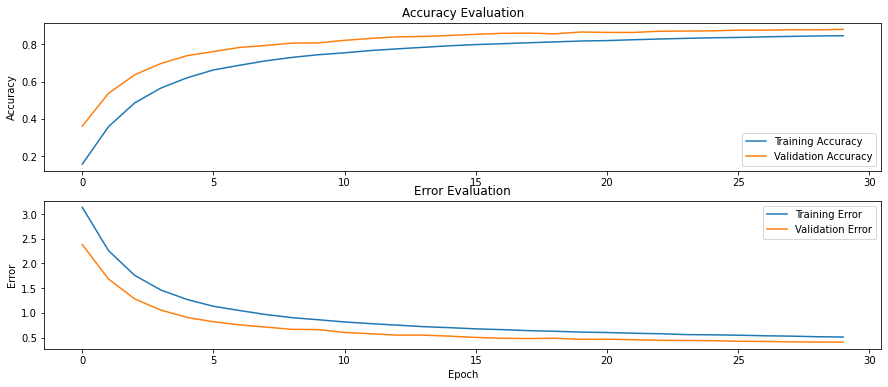

In [71]:
plot_training_history(history)